# 4. Data preprocessing

The first step is to activate the packages and load the data.

In [1]:
import pyreadr 

from plotnine import *
from plotnine.data import *

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression #사용
from sklearn.feature_selection import f_regression


In [3]:
data_ml = pyreadr.read_r(# insert path of data_ml.RData)
data_ml = data_ml["data_ml"]

In [4]:
data_ml.date = pd.to_datetime(data_ml.date)

data_ml = data_ml.loc[(data_ml['date'] > "1999-12-31") & (data_ml['date'] < "2019-01-01")]
data_ml.sort_values(by = ['stock_id','date'], inplace = True)

We also recycle a few variables from Chapter 2: feature names essentially.

In [5]:
features = list(data_ml.columns[2:95]) 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                    "Ocf", "Pb", "Vol1Y_Usd"]

Below, we show a box-plot that illustrates the distribution of correlations between features and the one month ahead return. The correlations are computed on a date-by-date basis, over the whole cross-section of stocks. 


Text(0.5, 0, 'Predictor')

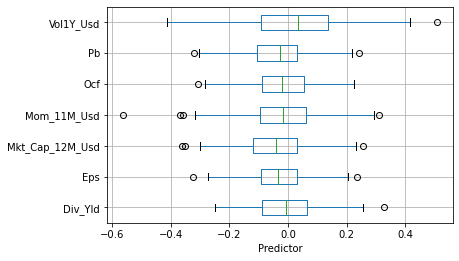

In [6]:
data_ml_corr  = data_ml[features_short + ["R1M_Usd", "date"]].groupby('date').corr().R1M_Usd.reset_index(level=1)
data_ml_corr = data_ml_corr.loc[data_ml_corr.level_1 !="R1M_Usd" ]
data_ml_corr = data_ml_corr.boxplot(by='level_1' , vert =False) 
### another way
# data_ml_corr = {}
# for dt, gp in data_ml.groupby('date'):
#     corr = gp[feature_short+ ["R1M_Usd"]].corr()['R1M_Usd'][:-1]
    
#     for key in corr.keys():
#         if key in data_ml_corr:
#             data_ml_corr[key] = data_ml_corr[key] + [corr[key]]
#         else:
#             data_ml_corr[key] = [corr[key]]


plt.title('')
plt.suptitle('') 
plt.xlabel('Predictor')

Below, we plot two illustrations of the smoothed **conditional average** when the dependent variable is the one month ahead return. Sometimes, this function is called the **regression function**.

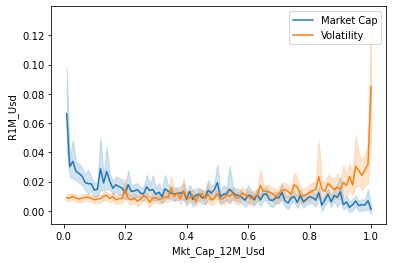

In [7]:
sns.lineplot(x="Mkt_Cap_12M_Usd", y="R1M_Usd",
               data=data_ml)
sns.lineplot(x="Vol1Y_Usd", y="R1M_Usd",
               data=data_ml)
plt.legend(labels=['Market Cap', 'Volatility'])

Below, we build the histogram of autocorrelations, computed stock by stock and feature by feature. It takes a bit of time.

<AxesSubplot:>

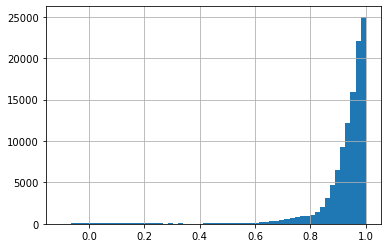

In [8]:
data_ml_feat = data_ml[["stock_id"]+ features]                                 
data_ml_feat_melt = pd.melt(data_ml_feat, id_vars="stock_id")
autocorrs = data_ml_feat_melt.groupby(['stock_id', 'variable']).value.apply(pd.Series.autocorr, lag=1)
autocorrs = autocorrs.reset_index()
autocorrs.value.hist(bins=60, range=(-0.1,1))

We then turn to a simple illustration of the different scaling methods. We generate an arbitrary series and then rescale it. The series is not random so that each time the code chunk is executed, the output remains the same.


<BarContainer object of 100 artists>

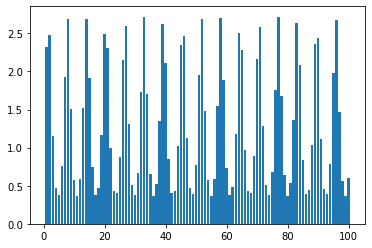

In [9]:
length = 100
x = np.exp( np.sin(  np.arange(1, length + 1, 1)))
plt.bar(np.arange(1, length + 1, 1), x)

We define and plot the scaled variables below.

In [10]:
def ecdf(x):
    xs = np.sort(x)
    return xs

def norm_unif(x):  # This is a function that uniformalises a vector
    xs = ecdf(x) 
    ys=[]
    for i in x:
        for j in range(len(x)):
            if i == xs[j]:
                ys.append( (j+1)/len(x))
    return ys


def norm_0_1(x):
    return((x-min(x))/(max(x)-min(x)))

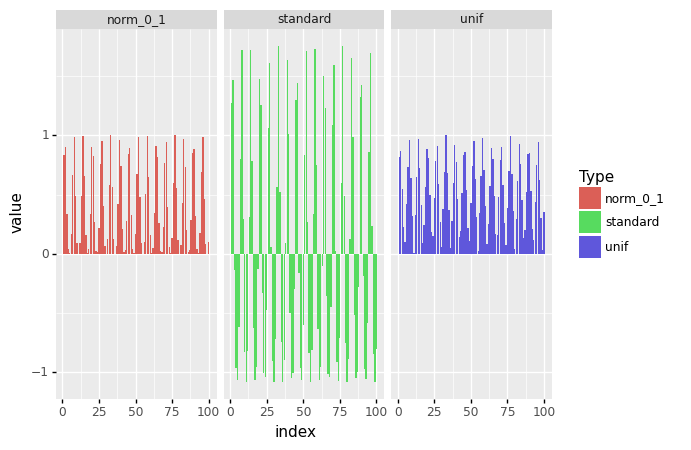

<ggplot: (166626562813)>

In [11]:
data_norm = pd.DataFrame()
data_norm['index'] =  np.arange(1,101)
data_norm['standard'] = (x - x.mean())/ x.std(ddof=1)
data_norm['norm_0_1'] = norm_0_1(x)
data_norm['unif'] = norm_unif(x)


data_norm  = pd.melt(data_norm, id_vars = "index", var_name ="Type")

#########If you use sns instead of plotnine
# g = sns.catplot(x="index", y="value", row="Type",data=data_norm, kind="bar", hue="Type",
#                 height=3,aspect=3)
# (g.set_axis_labels("index", "value")
#  # .set_xticklabels(['0','25','50','75'])
#   .set(ylim=(-1.5, 2)))
# xlabels = ['0','25','50','75','100']


(
    ggplot(data_norm, aes(x='index', y='value', fill='Type'))
    + geom_bar(stat = "identity")
    + facet_wrap('Type')
    
)

Finally, we look at the histogram of the newly created variables.

C:\Users\minho\Anaconda3\lib\site-packages\plotnine\stats\stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 13'. Pick better value with 'binwidth'.


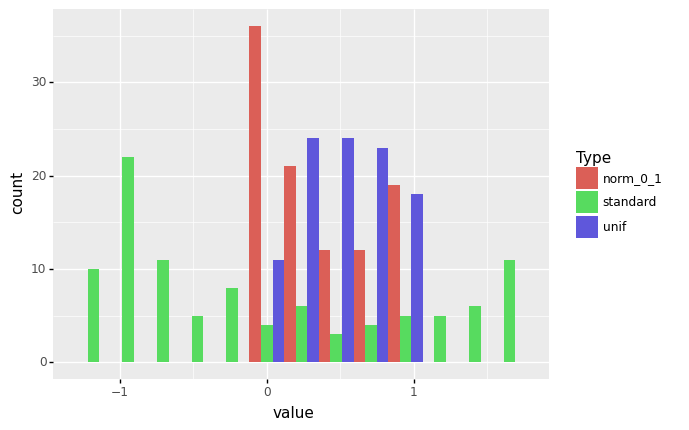

<ggplot: (166626562610)>

In [12]:
ggplot(data_norm, aes(x = 'value', fill = 'Type')) + geom_histogram(position = "dodge")

Finally, to illustrate the impact of chosing one particular rescaling method, we build a simple dataset, comprising 3 firms and 3 dates. 


In [13]:
firm = np.repeat([1, 2, 3], 3)
date = np.array([1, 2, 3] * 3)
cap = np.array([10, 50, 100,                               # Market capitalisation
         15, 10, 15, 
         200, 120, 80])
return_val = [0.06, 0.01, -0.06,                      # Return values
            -0.03, 0.00, 0.02,
            -0.04, -0.02,0.00]

data_toy = pd.DataFrame()
data_toy['firm'] = firm
data_toy['date'] = date
data_toy['cap'] = cap
data_toy['return'] = return_val

data_toy['cap_0_1'] = data_toy.groupby('date')['cap'].transform(lambda x:  norm_0_1(x))
data_toy['cap_u'] = data_toy.groupby('date')['cap'].transform(lambda x:  norm_unif(x))
data_toy

,firm,date,cap,return,cap_0_1,cap_u
0,1,1,10,0.06,0.000000,0.333333
1,1,2,50,0.01,0.363636,0.666667
2,1,3,100,-0.06,1.000000,1.000000
3,2,1,15,-0.03,0.026316,0.666667
4,2,2,10,0.00,0.000000,0.333333
5,2,3,15,0.02,0.000000,0.333333
6,3,1,200,-0.04,1.000000,1.000000
7,3,2,120,-0.02,1.000000,1.000000
8,3,3,80,0.00,0.764706,0.666667


Now let us look at the output of simple regressions.

In [14]:
X = data_toy[['cap_0_1']].to_numpy()
y = data_toy['return'].to_numpy()

loadings_reg = LinearRegression()
loadings_reg.fit(X, y)
f_val, p_val = f_regression(X, y)
print("coeff",loadings_reg.coef_, "intercetp", loadings_reg.intercept_, "p.value", p_val)


coeff [-0.04970324] intercetp 0.01627777601478484 p.value [0.05294207]


In [15]:
X = data_toy[['cap_u']].to_numpy()
loadings_reg.fit(X, y)
f_val, p_val = f_regression(X, y)
print("coeff",loadings_reg.coef_, "intercetp", loadings_reg.intercept_, "p.value", p_val)

coeff [-0.1] intercetp 0.059999999999999984 p.value [0.00835093]


In terms of *p*-**value** (last column), the first estimate for the cap coefficient is above 5%  while the second is below 1%.
